<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#Нейросеть" data-toc-modified-id="Нейросеть-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Нейросеть</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. 

**Задача:** Построить модель для предсказания количества заказов на следующий час.

**Метрика:** Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

**Шаги выполнения**:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
!pip install skorch 

     |████████████████████████████████| 193 kB 1.3 MB/s eta 0:00:01


In [2]:
import pandas as pd 
import numpy as np
import torch 
import torch.nn as nn 
from torch.utils.data import Dataset, DataLoader
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV, TimeSeriesSplit 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor
from skorch.callbacks import EpochScoring, EarlyStopping
from skorch import NeuralNetRegressor
from skorch.dataset import ValidSplit
pd.options.display.float_format = '{:20,.2f}'.format 

In [3]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0]) 

In [4]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
data = data.sort_index() 

In [6]:
# проверяем хронлогический порядок
data.index.is_monotonic 

True

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [8]:
# сделаем ресемплирование к одному часу
data = data.resample('1H').sum() 

<AxesSubplot:xlabel='datetime'>

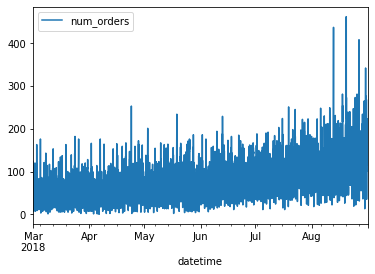

In [9]:
data.plot()

По временному ряду сразу очевиден тренд на увеличение количества заказов со временем.

## Анализ

Чтобы выявить закономерности временного ряда, разложим его на тренды и сезонность.

In [10]:
# раскладываем ряд на тренды и сезонность
decomposed = seasonal_decompose(data) 

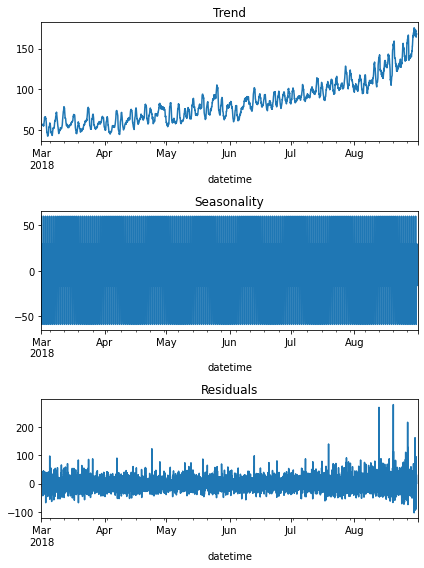

In [11]:
plt.figure(figsize=(6, 8))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

В принципе ничего нового не появилось - всё тот же тренд увеличения.

Посмотрим сезонность на более коротком промежутке времени в один день.

<AxesSubplot:xlabel='datetime'>

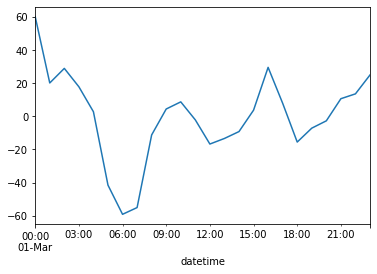

In [12]:
# график сезонной составляющей за один день
decomposed.seasonal['2018-03-01'].plot()

Для дополнительного анализа используем сглаживание ряда скользящим средним.

In [13]:
def plotMovingAverage(series, n):

    rolling_mean = series.rolling(window=n).mean()

    plt.figure(figsize=(15,5))

    plt.plot(data[n:], label="Actual values")
    
    plt.title("Moving average\n window size = {}".format(n))
    plt.plot(rolling_mean, "r", label="Rolling mean trend")
    
    plt.legend(loc="upper left")
    plt.grid(True)

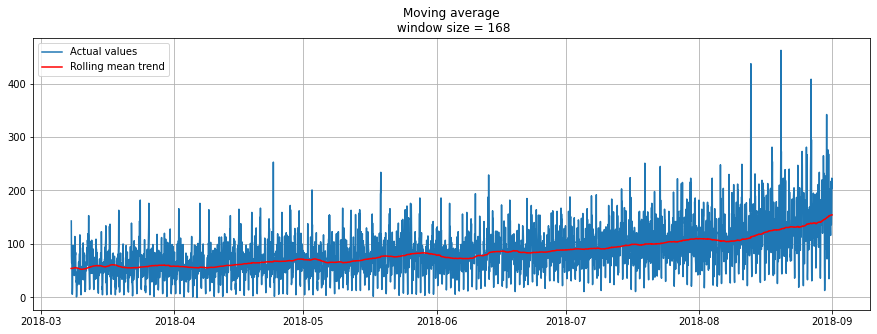

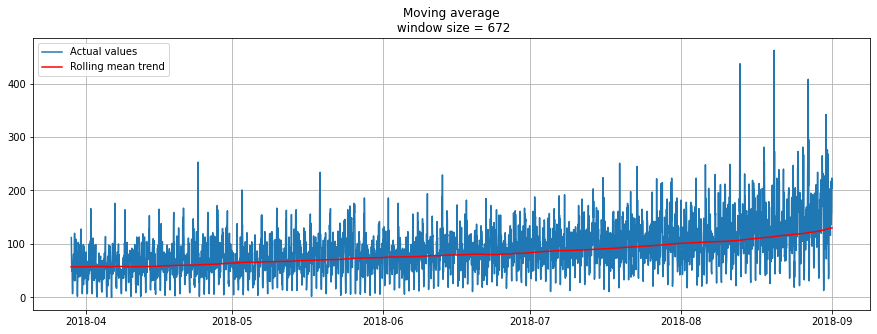

In [14]:
plotMovingAverage(data, 24*7) # сглаживаем по дням
plotMovingAverage(data, 24*28) # сглаживаем по месяцам

По полученному графику можно заметить, что в начале месяца иногда наблюдается спад.

## Обучение

In [16]:
# функция для генерации новых признаков: месяц, день, день недели, скользящее среднее, отстающие значения
def make_features(data, max_lag, rolling_mean_size):
    
    df = data.copy()
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
    
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return df 

In [17]:
# # разбиваем данные на тестовую и обучающую выборки
data = make_features(data, 24, 10)

train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

print(train.shape)
print(test.shape)

train_features = train.drop('num_orders', axis=1)
train_target = train['num_orders']

test_features = test.drop('num_orders', axis=1)
test_target = test['num_orders']

2018-03-02 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00
(3950, 29)
(442, 29)


In [18]:
# применим масштабирование, чтобы потом использовать с нейросетью
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

### Линейная регрессия

In [19]:
# настройка кросс-валидатора
tss = TimeSeriesSplit(n_splits=5)

In [20]:
# получаем метрику на обучающей выборке
lr = LinearRegression()
'{:.20f}'.format(cross_val_score(lr, train_features, train_target, scoring='neg_root_mean_squared_error', cv=tss).mean())

'-27.02027797882152526654'

### CatBoost

In [21]:
# базовая модель catboost
catb = CatBoostRegressor(random_state=42,  
                         iterations=100,
                         early_stopping_rounds=10,
                         learning_rate=0.1)

In [22]:
%%time
params_catb = {
    'depth': [6, 7, 8],
    'min_data_in_leaf': [1, 2, 3, 4]
}

grid_catb = GridSearchCV(catb, param_grid=params_catb, cv=tss,
                        scoring='neg_root_mean_squared_error').fit(train_features, train_target, verbose=3) 

0:	learn: 28.3422530	total: 51.5ms	remaining: 5.1s
3:	learn: 25.2944473	total: 60.5ms	remaining: 1.45s
6:	learn: 22.8852162	total: 69.4ms	remaining: 922ms
9:	learn: 21.1328490	total: 77.9ms	remaining: 701ms
12:	learn: 19.8093399	total: 86.5ms	remaining: 579ms
15:	learn: 18.8192028	total: 95.2ms	remaining: 500ms
18:	learn: 18.0467777	total: 104ms	remaining: 443ms
21:	learn: 17.4272608	total: 112ms	remaining: 399ms
24:	learn: 16.7875958	total: 121ms	remaining: 363ms
27:	learn: 16.2317358	total: 130ms	remaining: 334ms
30:	learn: 15.8120386	total: 139ms	remaining: 309ms
33:	learn: 15.3516546	total: 148ms	remaining: 287ms
36:	learn: 14.9991957	total: 156ms	remaining: 266ms
39:	learn: 14.7537856	total: 164ms	remaining: 247ms
42:	learn: 14.5589072	total: 173ms	remaining: 229ms
45:	learn: 14.3127322	total: 181ms	remaining: 213ms
48:	learn: 14.0608203	total: 190ms	remaining: 198ms
51:	learn: 13.8001578	total: 199ms	remaining: 183ms
54:	learn: 13.5709265	total: 207ms	remaining: 169ms
57:	learn: 

In [23]:
results = grid_catb.cv_results_
best_index = grid_catb.best_index_

fit_time = results['mean_fit_time'].mean()
score_time = results['mean_score_time'].mean()
RMSE = results['mean_test_score'].max()

print(f"Fit time: {fit_time}\nPredict time: {score_time}\nBest RMSE: {RMSE}") 

Fit time: 1.3727472027142842
Predict time: 0.0025759180386861163
Best RMSE: -25.276851624973176


In [24]:
grid_catb.best_params_

{'depth': 8, 'min_data_in_leaf': 1}

### Нейросеть

In [25]:
class EarlyStopping_1():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, patience=5, min_delta=0):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            # reset counter if validation loss improves
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True 

In [26]:
# гиперпараметры нейросети
num_epochs = 200
batch_size = 1000
loss = nn.MSELoss() 
learning_rate = 0.01
early_stopping = EarlyStopping_1() 

In [27]:
X_train_tensor = torch.from_numpy(train_features_scaled).float()
X_test_tensor = torch.from_numpy(test_features_scaled).float()

y_train_tensor = torch.from_numpy(np.array(train_target)).float() 
y_test_tensor = torch.from_numpy(np.array(test_target)).float() 

dataset_train = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor) 
dataset_test = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)  


train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True,
                              num_workers=0)
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, num_workers=0) 

In [28]:
class Basic_Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
        super(Basic_Net, self).__init__()
        self.layer1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.layer2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.layer3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
        
    def forward(self, x):
        x = self.layer1(x)
        x = torch.relu(x) 
        x = self.layer2(x)
        x = torch.relu(x) 
        x = self.layer3(x)
        x = torch.relu(x)
        
        return x

In [29]:
# инициализация весов
def init_weights(layer):
    if type(layer) == nn.Linear:
        nn.init.xavier_uniform_(layer.weight)

In [30]:
n_in_neurons = X_train_tensor.size(dim=1)
n_out_neurons = 1
n_hidden_neurons_1 = 20
n_hidden_neurons_2 = 10

In [31]:
basic_net = Basic_Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)
basic_net.apply(init_weights)
optimizer = torch.optim.Adam(basic_net.parameters(), lr=learning_rate)

In [32]:
skorch_regressor = NeuralNetRegressor(module=basic_net, 
                                      device='cpu',  
                                      verbose=3,
                                      batch_size=batch_size,
                                      optimizer=torch.optim.Adam, 
                                      max_epochs=20, 
                                      lr=learning_rate,
                                      #train_split=ValidSplit(cv=5),
                                      callbacks=[
                ('rmse', EpochScoring(scoring='neg_root_mean_squared_error', lower_is_better=False)),
                ('estoper', EarlyStopping(lower_is_better=False, monitor='neg_root_mean_squared_error')),
            ],
                                     ) 

In [33]:
params = {
    'module__n_in_neurons': [n_in_neurons],
    'module__n_hidden_neurons_1': range(10, 30, 5),
    'module__n_hidden_neurons_2': range(10, 30, 5),
    'module__n_out_neurons': [n_out_neurons],
    #'lr': [1e-3, 1e-4]
}

In [34]:
grid = RandomizedSearchCV(skorch_regressor, params, cv=tss, scoring="neg_root_mean_squared_error", verbose=3) 
grid.fit(X_train_tensor, y_train_tensor.reshape(-1,1)) 

Fitting 5 folds for each of 10 candidates, totalling 50 fits
  epoch    neg_root_mean_squared_error    train_loss    valid_loss     dur
-------  -----------------------------  ------------  ------------  ------
      1                       -59.7861     4265.3828     3574.3767  0.0137
      2                       -59.6299     4249.9131     3555.7297  0.0069
      3                       -59.4006     4229.5439     3528.4331  0.0077
      4                       -59.0885     4201.0078     3491.4521  0.0087
      5                       -58.6816     4162.9492     3443.5278  0.0081
      6                       -58.1615     4113.7739     3382.7551  0.0067
      7                       -57.5108     4051.3020     3307.4961  0.0064
      8                       -56.7117     3973.8433     3216.2119  0.0581
      9                       -55.7458     3879.8628     3107.5999  0.0062
     10                       -54.5957     3767.8933     2980.6907  0.0057
     11                       -53.2441 

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=<class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=Basic_Net(
    (layer1): Linear(in_features=28, out_features=20, bias=True)
    (layer2): Linear(in_features=20, out_features=10, bias=True)
    (layer3): Linear(in_features=10, out_features=1, bias=True)
  ),
),
                   param_distributions={'module__n_hidden_neurons_1': range(10, 30, 5),
                                        'module__n_hidden_neurons_2': range(10, 30, 5),
                                        'module__n_in_neurons': [28],
                                        'module__n_out_neurons': [1]},
                   scoring='neg_root_mean_squared_error', verbose=3)

In [35]:
grid.best_params_ 

{'module__n_out_neurons': 1,
 'module__n_in_neurons': 28,
 'module__n_hidden_neurons_2': 20,
 'module__n_hidden_neurons_1': 20}

In [36]:
grid.best_score_

-49.2733757019043

Нейросеть работает значительно хуже, чем линейная регрессия и catboost. Возможно, это связано с тем, что для задач временных рядов используют рекуррентные нейросети.

## Тестирование

На кросс-валидации лучше всего себя показала модель catboost, поэтому её и будем тестировать.

In [42]:
catb = CatBoostRegressor(random_state=42,  
                         iterations=100,
                         early_stopping_rounds=10,
                         learning_rate=0.1,
                         depth=8,
                         min_data_in_leaf=1)

In [43]:
catb.fit(train_features, train_target, verbose=3)

0:	learn: 36.9051167	total: 28.8ms	remaining: 2.85s
3:	learn: 32.6891135	total: 76.8ms	remaining: 1.84s
6:	learn: 29.8065571	total: 124ms	remaining: 1.64s
9:	learn: 27.7296584	total: 173ms	remaining: 1.55s
12:	learn: 26.2032926	total: 222ms	remaining: 1.49s
15:	learn: 25.0438543	total: 273ms	remaining: 1.43s
18:	learn: 24.2192070	total: 320ms	remaining: 1.36s
21:	learn: 23.4924888	total: 368ms	remaining: 1.3s
24:	learn: 22.8789816	total: 413ms	remaining: 1.24s
27:	learn: 22.4582083	total: 459ms	remaining: 1.18s
30:	learn: 22.1292464	total: 507ms	remaining: 1.13s
33:	learn: 21.8187675	total: 562ms	remaining: 1.09s
36:	learn: 21.5444012	total: 609ms	remaining: 1.04s
39:	learn: 21.3509513	total: 656ms	remaining: 984ms
42:	learn: 21.1002415	total: 704ms	remaining: 934ms
45:	learn: 20.9567196	total: 754ms	remaining: 885ms
48:	learn: 20.7847778	total: 804ms	remaining: 837ms
51:	learn: 20.4858901	total: 851ms	remaining: 785ms
54:	learn: 20.3130706	total: 898ms	remaining: 734ms
57:	learn: 20.1

In [44]:
preds = catb.predict(test_features)

In [45]:
np.sqrt(mean_squared_error(test_target, preds))

43.41670645760493

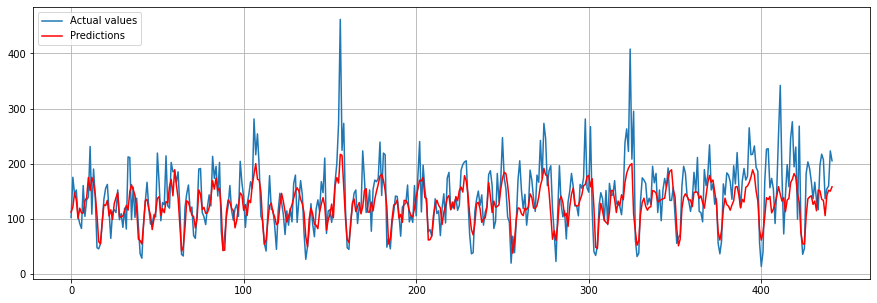

In [46]:
# визаулизируем результаты предсказаний в сравнении с действительными значениями
plt.figure(figsize=(15,5))

plt.plot(test_target.values, label="Actual values")

plt.plot(preds, "r", label="Predictions")

plt.legend(loc="upper left")
plt.grid(True)
plt.show()

## Общий вывод

В целом, модель CatBoost неплохо прогнозирует количество заказов такси, но не справляется с выбросными значениями.